In [1]:
# Dependencies
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import calendar
import statsmodels.formula.api as sm
from datetime import datetime

In [2]:
def distance(row):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = row['pickup_latitude'], row['pickup_longitude']
    lat2, lon2 = row['dropoff_latitude'], row['dropoff_longitude']
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [3]:
test_data = pd.read_csv("Resources/test.csv")
#full_data = pd.read_csv("Resources/train.csv")
#sample_data = full_data.sample(n=20000)
#sample_data.tail()
#sample_data.to_csv("Resources/sample.csv")

In [4]:
data_df = pd.read_csv("Resources/sample.csv")
data_df.tail()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
19995,18577093,2011-04-26 10:01:00.000000186,4.10,2011-04-26 10:01:00 UTC,-73.981243,40.774312,-73.983778,40.767743,3
19996,53404964,2014-10-01 21:41:34.0000004,28.50,2014-10-01 21:41:34 UTC,-74.007112,40.718224,-73.934912,40.798347,1
19997,8754196,2013-08-18 19:56:05.0000002,34.33,2013-08-18 19:56:05 UTC,-73.863623,40.769963,-73.993245,40.736136,1
19998,27909592,2009-10-02 19:45:00.000000283,5.70,2009-10-02 19:45:00 UTC,-73.984912,40.759793,-73.991323,40.749993,2
19999,33205722,2013-06-10 07:14:54.0000001,21.00,2013-06-10 07:14:54 UTC,-73.992033,40.768967,-73.980294,40.714079,1


In [5]:
data_df['new_time'] = (data_df['pickup_datetime']).apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z"))    
data_df = data_df.drop(['Unnamed: 0','key','pickup_datetime'], axis=1)
time_range = (data_df['new_time'] > "2013-01-01") & (data_df['new_time'] < "2016-12-31")
ranged_data = data_df.loc[time_range]



In [6]:
ranged_data['distance'] = data_df.apply(distance, axis=1)



/Users/saurabhgoyal/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,new_time,distance
19992,4.00,-73.951087,40.782975,-73.944410,40.787859,1,2014-03-21 20:10:03,0.781632
19994,10.00,-73.962387,40.778793,-73.977386,40.758976,3,2015-06-13 14:10:28,2.539951
19996,28.50,-74.007112,40.718224,-73.934912,40.798347,1,2014-10-01 21:41:34,10.786837
19997,34.33,-73.863623,40.769963,-73.993245,40.736136,1,2013-08-18 19:56:05,11.548249
19999,21.00,-73.992033,40.768967,-73.980294,40.714079,1,2013-06-10 07:14:54,6.182877


/Users/saurabhgoyal/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/saurabhgoyal/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/saurabhgoyal/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

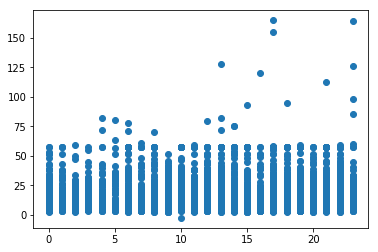

In [15]:
ranged_data['year'] = data_df['new_time'].apply(lambda x: x.year)
ranged_data['hour_of_day'] = data_df['new_time'].apply(lambda x: x.hour)
ranged_data['day'] = data_df['new_time'].apply(lambda x: calendar.day_name[x.weekday()])
ranged_data['date'] = data_df['new_time'].apply(lambda x: x.date())
ranged_data.tail()
plt.scatter(ranged_data['hour_of_day'],ranged_data['fare_amount'])


In [8]:
ranged_data.dtypes
ranged_data[['year', 'hour_of_day']] = ranged_data[['year', 'hour_of_day']].astype(str)
ranged_data.tail()

/Users/saurabhgoyal/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,new_time,distance,year,hour_of_day,day,date
19992,4.00,-73.951087,40.782975,-73.944410,40.787859,1,2014-03-21 20:10:03,0.781632,2014,20,Friday,2014-03-21
19994,10.00,-73.962387,40.778793,-73.977386,40.758976,3,2015-06-13 14:10:28,2.539951,2015,14,Saturday,2015-06-13
19996,28.50,-74.007112,40.718224,-73.934912,40.798347,1,2014-10-01 21:41:34,10.786837,2014,21,Wednesday,2014-10-01
19997,34.33,-73.863623,40.769963,-73.993245,40.736136,1,2013-08-18 19:56:05,11.548249,2013,19,Sunday,2013-08-18
19999,21.00,-73.992033,40.768967,-73.980294,40.714079,1,2013-06-10 07:14:54,6.182877,2013,7,Monday,2013-06-10


In [9]:
dummied_data = ranged_data

for column in dummied_data.columns:
 if dummied_data[column].dtype==object:
  dummyCols=pd.get_dummies(dummied_data[column])
  dummied_data=dummied_data.join(dummyCols)
  del dummied_data[column]

dummied_data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,new_time,distance,2013,2014,...,2015-06-21,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-27,2015-06-28,2015-06-29,2015-06-30
4,17.0,-74.014908,40.709413,-73.995570,40.723334,2,2013-08-05 11:25:13,2.247754,1,0,...,0,0,0,0,0,0,0,0,0,0
7,34.3,-73.970609,40.752434,-73.865204,40.770544,1,2013-02-25 05:59:59,9.103036,1,0,...,0,0,0,0,0,0,0,0,0,0
12,6.5,-74.007595,40.743177,-73.995228,40.749812,2,2013-03-13 19:44:00,1.276598,1,0,...,0,0,0,0,0,0,0,0,0,0
13,6.0,-73.990842,40.750535,-73.983902,40.751405,3,2014-09-04 09:10:00,0.592549,0,1,...,0,0,0,0,0,0,0,0,0,0
18,3.0,-73.982262,40.768997,-73.988022,40.770638,1,2015-06-02 11:01:41,0.518237,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
result = sm.ols(formula="fare_amount ~distance + year + hour_of_day + day + date", data=ranged_data).fit()
result.summary()